In [98]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [99]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [100]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [101]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [16]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.ones(1, n_hidden)
bnstd_running = torch.zeros(1, n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [17]:
hpreact.shape

torch.Size([182580, 200])

In [18]:
nums = torch.tensor([np.arange(9)]).view(3, 3).float()
nums

/var/folders/70/z5v4k8l11vs05yb6dxp5c8m40000gn/T/ipykernel_34053/3665034663.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391829313/work/torch/csrc/utils/tensor_new.cpp:264.)
  nums = torch.tensor([np.arange(9)]).view(3, 3).float()


tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [19]:
nums.mean(0, keepdims=True)

tensor([[3., 4., 5.]])

In [20]:
hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

In [21]:
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

In [22]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  
  bnmeani = hpreact.mean(0, keepdims=True)
  bnstdi = hpreact.std(0, keepdims=True)
  hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
  
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  


      0/ 200000: 3.2856
  10000/ 200000: 2.1340
  20000/ 200000: 2.1373
  30000/ 200000: 2.2285
  40000/ 200000: 2.0133
  50000/ 200000: 1.7307
  60000/ 200000: 2.2741
  70000/ 200000: 2.2340
  80000/ 200000: 2.3828
  90000/ 200000: 2.0722
 100000/ 200000: 2.2072
 110000/ 200000: 2.1703
 120000/ 200000: 2.2788
 130000/ 200000: 1.8803
 140000/ 200000: 1.7875
 150000/ 200000: 2.1805
 160000/ 200000: 1.9339
 170000/ 200000: 1.9587
 180000/ 200000: 2.1038
 190000/ 200000: 2.0363


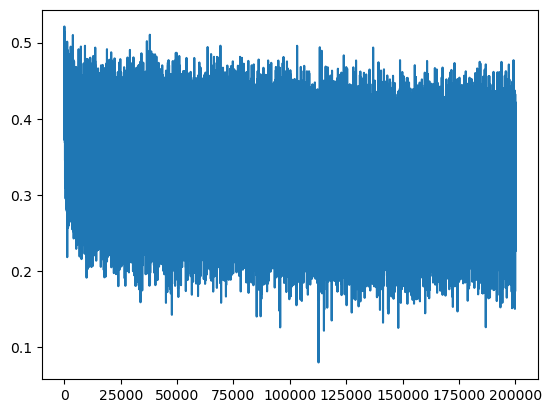

In [23]:
plt.plot(lossi)

In [12]:
# with torch.no_grad():
#   emb = C[Xtr]
#   embcat = emb.view(emb.shape[0], -1)
#   hpreact = embcat @ W1 + b1
#   bnmean = hpreact.mean(0, keepdims=True)
#   bnstd = hpreact.std(0, keepdims=True)

In [24]:
@torch.no_grad()
def split_loss(split):
  x, y = {'train': (Xtr, Ytr),
          'val': (Xdev, Ydev),
          'test': (Xte, Yte)
          }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 #+b1
  hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('val')
  

train 2.1368637084960938
val 2.1810243129730225


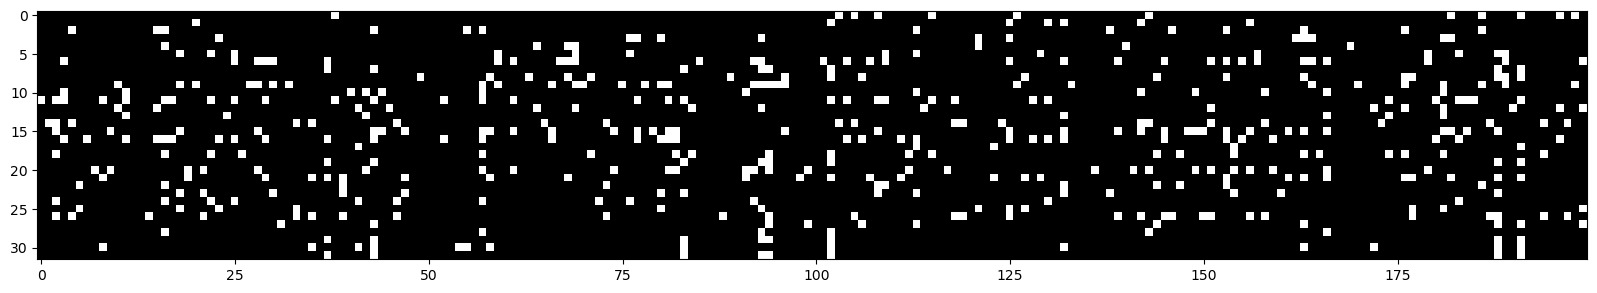

In [49]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

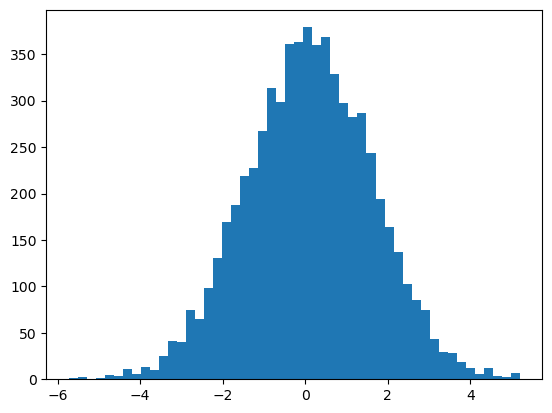

In [50]:
plt.hist(hpreact.view(-1).tolist(), 50);

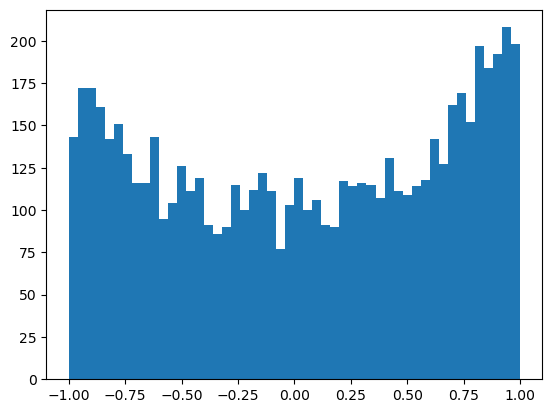

In [45]:
plt.hist(h.view(-1).tolist(), 50); # Why is this a problem? hint: derivative of tanh

### Pytorch-ifying

In [205]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])
  

class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
    
  def __call__(self, x):
    if self.training:
      xmean = x.mean(0, keepdims=True)
      xvar = x.var(0, keepdims=True, unbiased=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta
    
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
      
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  
  def parameters(self):
    return []
      

In [208]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  layers[-1].gamma *= 0.1
  # layers[-1].weight *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *=  5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

47551


In [209]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix]
  
  emb = C[Xb]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)
  
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  
  loss.backward()
  
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr * p.grad).std()/ p.data.std()).log10().item() for p in parameters])
  
  if i >= 1000:
    break

      0/ 200000: 3.2978


layer 2 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 5 (      Tanh): mean +0.01, std 0.64, saturated: 2.75%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.62%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.66%


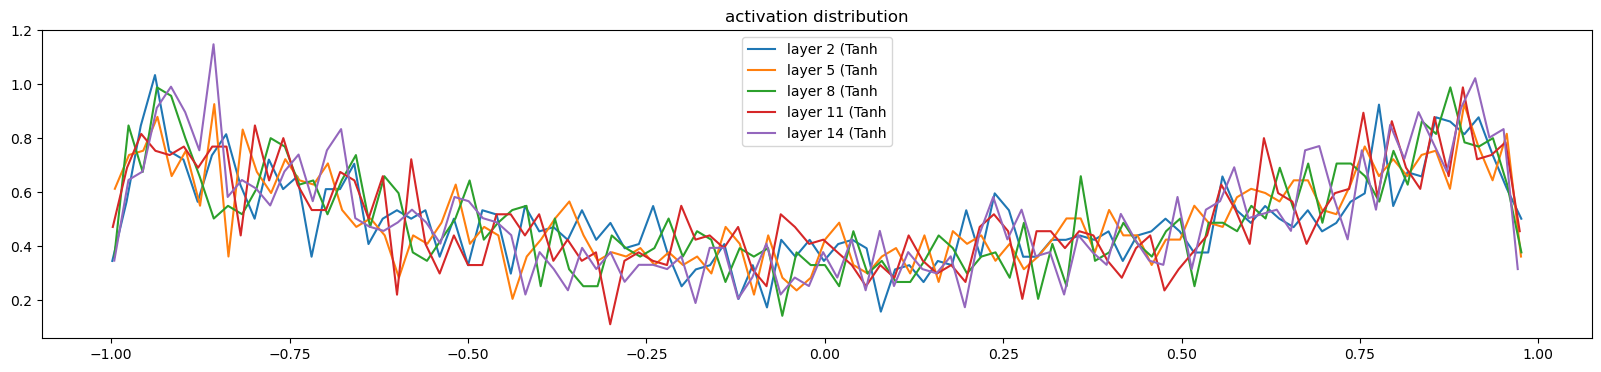

In [210]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution');

layer 2 (      Tanh): mean +0.002845, std -1.396984e-11
layer 5 (      Tanh): mean +0.002514, std 5.820766e-12
layer 8 (      Tanh): mean +0.002316, std -1.571607e-11
layer 11 (      Tanh): mean +0.002167, std 1.047738e-11
layer 14 (      Tanh): mean +0.002171, std -1.164153e-12


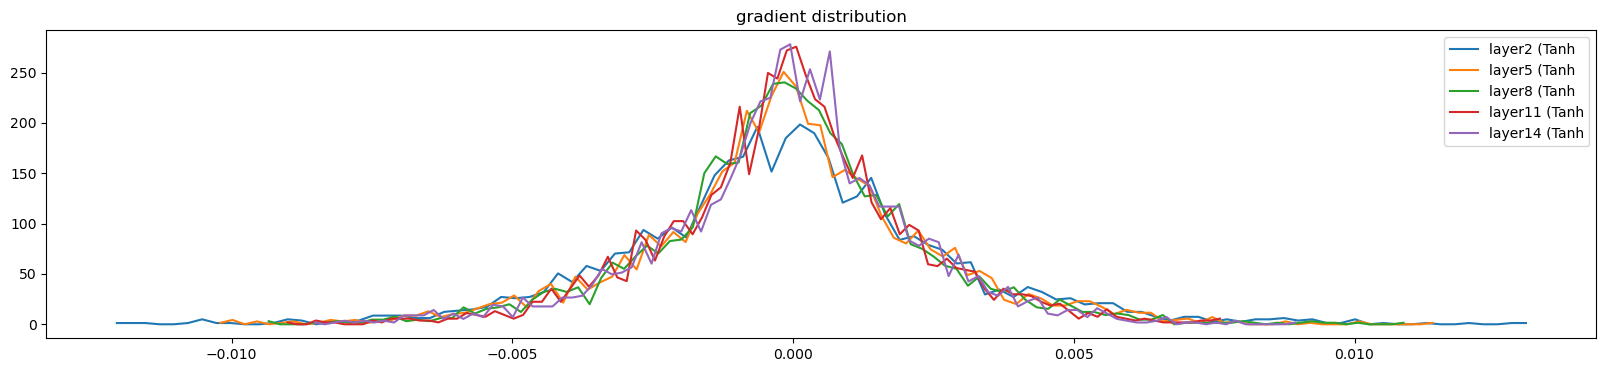

In [211]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.std(), t.mean()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer{i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution');

weight   (27, 10) | mean +0.000000 | std 8.376699e-03 | grad data ratio 9.039841e-03
weight  (30, 100) | mean -0.000120 | std 6.900094e-03 | grad data ratio 2.236879e-02
weight (100, 100) | mean -0.000035 | std 6.242385e-03 | grad data ratio 3.708778e-02
weight (100, 100) | mean -0.000045 | std 5.567188e-03 | grad data ratio 3.322454e-02
weight (100, 100) | mean -0.000006 | std 4.965812e-03 | grad data ratio 2.961312e-02
weight (100, 100) | mean +0.000026 | std 4.303203e-03 | grad data ratio 2.550468e-02
weight  (100, 27) | mean -0.000139 | std 8.595446e-03 | grad data ratio 5.158961e-02


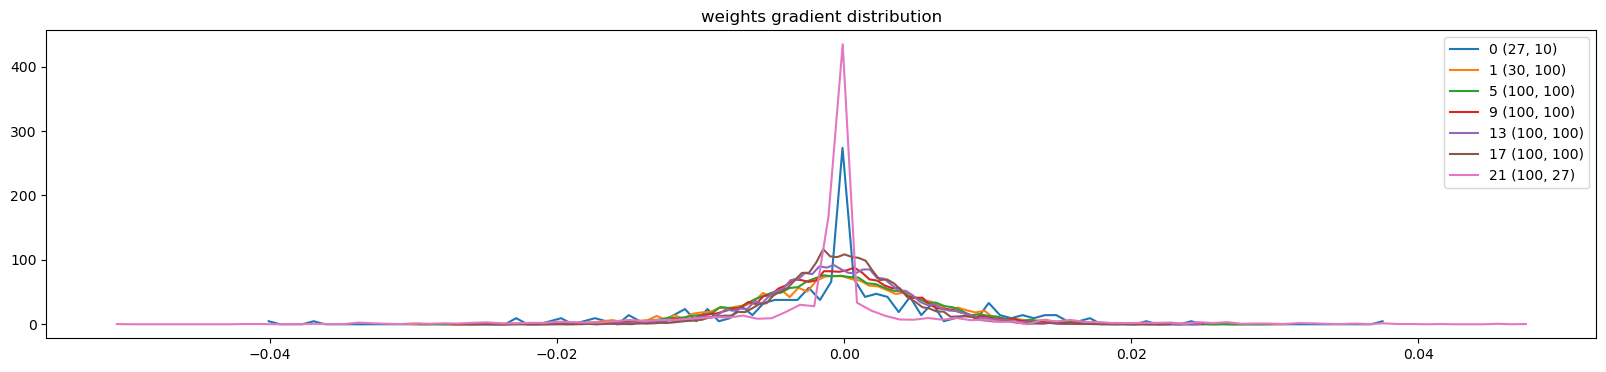

In [212]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad data ratio %e' %( tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

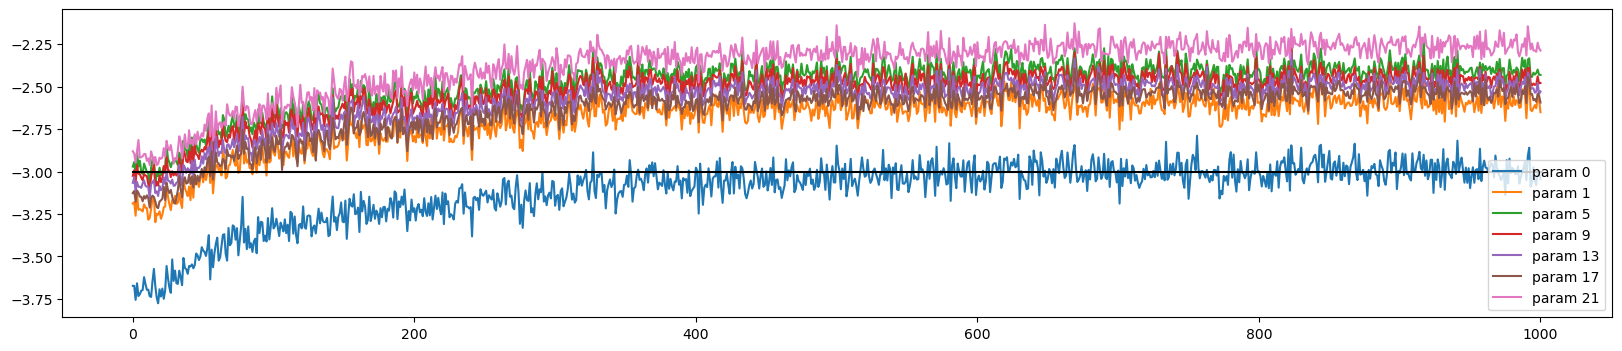

In [213]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);